In [1]:
import cv2
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

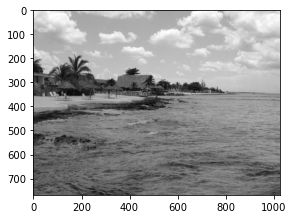

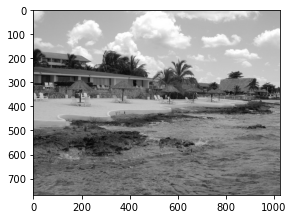

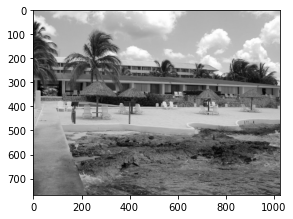

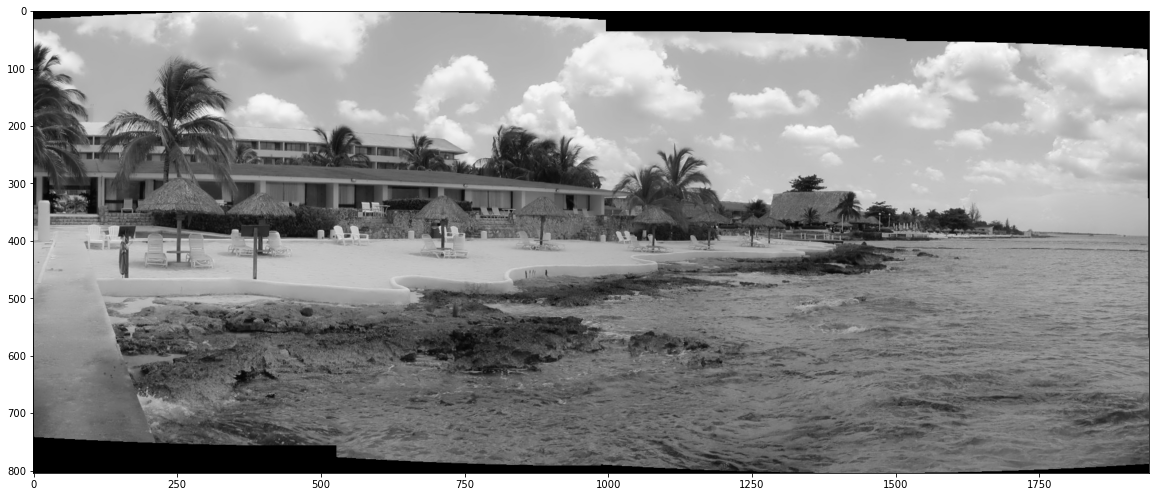

In [2]:
img_names = ['hotel-00.png', 'hotel-01.png', 'hotel-02.png']

imgs = []
for i, name in enumerate(img_names):
    img = cv2.imread(name)
    plt.figure(figsize=(15,15))
    plt.subplot(len(img_names)//3+1,3,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    imgs.append(img)

stitcher = cv2.Stitcher_create()

status, dst = stitcher.stitch(imgs)

s=0
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

In [3]:
def KeypointsMatching(keyPoints_L, keyPoints_R, descriptors_L, descriptors_R):

    bf = cv2.BFMatcher()
    raw_matches = bf.knnMatch(descriptors_L, descriptors_R, k=2)

    matches = []
    for m in raw_matches:
        if len(m) == 2 and m[0].distance < m[1].distance * 0.79:
            matches.append((m[0].trainIdx, m[0].queryIdx))

    if len(matches) >= 4:

        keyPoints_L = np.float32([keyPoints_L[i] for (_, i) in matches])
        keyPoints_R = np.float32([keyPoints_R[i] for (i, _) in matches])

        H, status = cv2.findHomography(keyPoints_L, keyPoints_R, cv2.RANSAC, 4.0)


    return matches, H, status

In [4]:
def Draw_with_Matching(image_L, image_R, keyPoints_L, keyPoints_R, matches, status):
    h1, w1 = image_L.shape[:2]
    h2, w2 = image_R.shape[:2]

    img_matching_result = np.zeros((max(h1, h2), w1 + w2, 3), dtype="uint8")

    img_matching_result[0:h2, 0:w2] = image_R
    img_matching_result[0:h1, w2:] = image_L

    for ((trainIdx, queryIdx), s) in zip(matches, status):

        if s == 1:
            keyPoint2 = (int(keyPoints_R[trainIdx][0]), int(keyPoints_R[trainIdx][1]))
            keyPoint1 = (int(keyPoints_L[queryIdx][0]) + w2, int(keyPoints_L[queryIdx][1]))
            cv2.line(img_matching_result, keyPoint1, keyPoint2, (0, 255, 0), 1)

    return img_matching_result

img1 - 5467 features, img2 - 5415 features


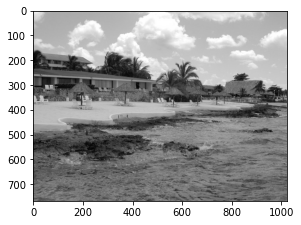

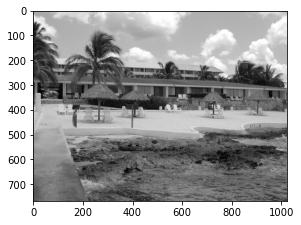

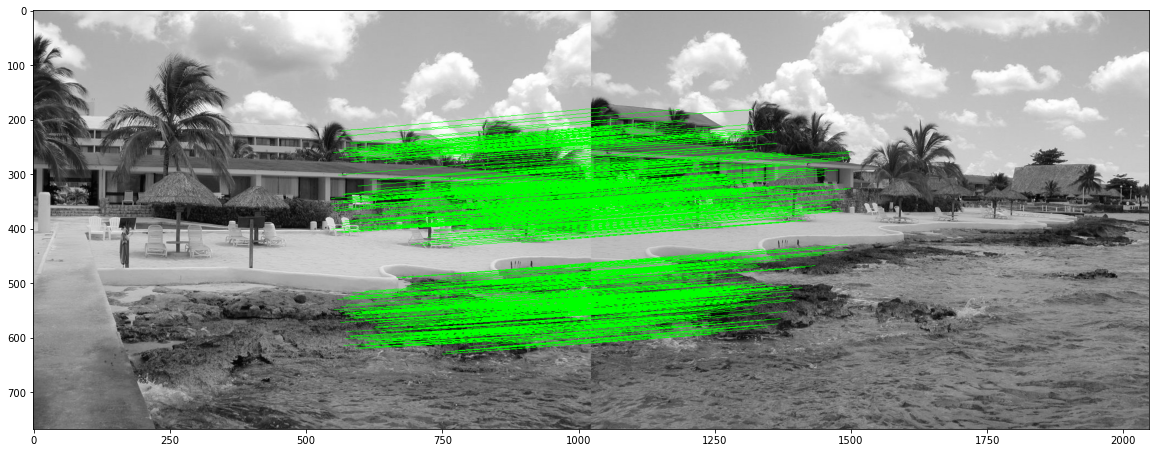

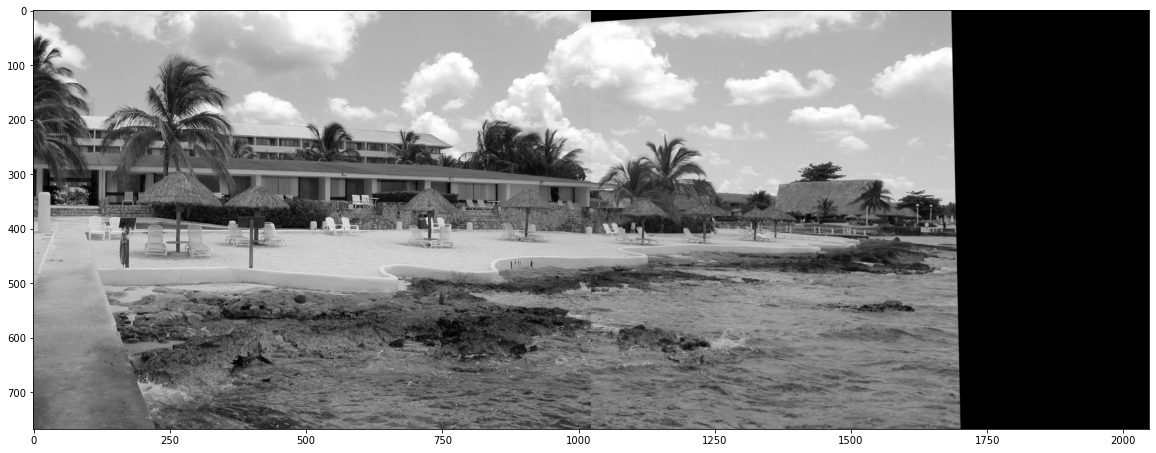

In [5]:
image_L = cv2.imread('hotel-01.png')
image_R = cv2.imread('hotel-02.png')

gray_L = cv2.cvtColor(image_L, cv2.COLOR_BGR2GRAY)
gray_R = cv2.cvtColor(image_R, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image_L, cv2.COLOR_BGR2RGB))

plt.figure(figsize=(10,10))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(image_R, cv2.COLOR_BGR2RGB))

detector = cv2.xfeatures2d.SIFT_create()
keyPoints_L, descriptors_L = detector.detectAndCompute(gray_L, None)
keyPoints_R, descriptors_R = detector.detectAndCompute(gray_R, None)
print('img1 - %d features, img2 - %d features' % (len(keyPoints_L), len(keyPoints_R)))

keyPoints_L = np.float32([keypoint.pt for keypoint in keyPoints_L])
keyPoints_R = np.float32([keypoint.pt for keypoint in keyPoints_R])

matches, H, status = KeypointsMatching(keyPoints_L, keyPoints_R, descriptors_L, descriptors_R)

img_matching_result = Draw_with_Matching(image_L, image_R, keyPoints_L, keyPoints_R, matches, status)

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(img_matching_result, cv2.COLOR_BGR2RGB))

result = cv2.warpPerspective(image_L, H,
                             (image_L.shape[1] + image_R.shape[1], image_L.shape[0]))
result[0:image_R.shape[0], 0:image_R.shape[1]] = image_R

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))